In [209]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay
%matplotlib inline


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

numpy version :  1.24.3
pandas version :  1.5.3
seaborn version :  0.12.2


In [210]:
df = pd.read_csv('loan_data_2007_2014.csv')

In [211]:
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [213]:
print("Total Rows :", df.shape[0])
print("Total Features :", df.shape[1])

Total Rows : 466285
Total Features : 75


## Data Exploration

In [214]:
df.duplicated().sum()

0

In [215]:
list_item = [] 
for col in df.columns: 
    list_item.append([col, df[col].dtype, df[col].isna().sum(), 100*df[col].isna().sum()/len(df[col]), df[col].nunique(), df[col].unique()[:5]]) 

desc_df = pd.DataFrame(data=list_item, columns='Feature,Data Type,Null, Null (%),Unique,Unique Sample'.split(","))
desc_df

,Feature,Data Type,Null,Null (%),Unique,Unique Sample
0,Unnamed: 0,int64,0,0.000000,466285,"[0, 1, 2, 3, 4]"
1,id,int64,0,0.000000,466285,"[1077501, 1077430, 1077175, 1076863, 1075358]"
2,member_id,int64,0,0.000000,466285,"[1296599, 1314167, 1313524, 1277178, 1311748]"
3,loan_amnt,int64,0,0.000000,1352,"[5000, 2500, 2400, 10000, 3000]"
4,funded_amnt,int64,0,0.000000,1354,"[5000, 2500, 2400, 10000, 3000]"
...,...,...,...,...,...,...
70,all_util,float64,466285,100.000000,0,[nan]
71,total_rev_hi_lim,float64,70276,15.071469,14612,"[nan, 59900.0, 15100.0, 61100.0, 8100.0]"
72,inq_fi,float64,466285,100.000000,0,[nan]
73,total_cu_tl,float64,466285,100.000000,0,[nan]


- There are some features which considered to be dropped

Unnamed: 0, id, and member_id are representing unique values for each rows.
policy code, and application type have only 1 value.
unnecessary features like title, url, zip_code, addr_state, and desc.
sub_grade seems like a form of expert judgement from grade
100% null values like annual_inc_joint, dti_joint, verification_status_joint, open_acc_6m, open_il_6m, open_il_12m, open_il_24m, mths_since_rcnt_il, total_bal_il, il_util, open_rv_12m, open_rv_24m, max_bal_bc, all_util, inq_fi,total_cu_tl, and inq_last_12m.

- Some features with < 20% of missing values will be maintained for imputation if possible

emp_title, emp_length, acc_now_delinq

- Some features with > 20% of missing values will have a higher probability of being dropped since performing imputation seems to have a huge impact on originality of the dataset.

mths_since_last_delinq, mths_since_last_record, next_pymnt_d,mths_since_last_major_derog

- Some features with date-like values will be converted to datetime

last_pymnt_d, next_pymnt_d, last_credit_pull_d, earliest_cr_line

- Some feature's datatype will be changed accordingly

term to integer
annual_inc to integer
loan_status is the target feature with categorical values, therefore feature engineering will be performed.

# Data Preparation

In [216]:
df_clean = df.copy()

## Handling Missing Values

In [217]:
# Total null values 
miss_null = df_clean.isnull().sum() 
perc_miss = df_clean.isnull().sum() * 100/ len(df) 
dtypes = [df_clean[col].dtype for col in df_clean.columns] 
df_miss_val = pd.DataFrame({'Total Null': miss_null, 'data_type': dtypes, 'Perc Missing': perc_miss}) 
df_miss_val.sort_values('Perc Missing', ascending = False,inplace = True) 
missing_value = df_miss_val[df_miss_val['Perc Missing']>0].reset_index() 
missing_value

,index,Total Null,data_type,Perc Missing
0,inq_last_12m,466285,float64,100.000000
1,total_bal_il,466285,float64,100.000000
2,dti_joint,466285,float64,100.000000
3,verification_status_joint,466285,float64,100.000000
4,annual_inc_joint,466285,float64,100.000000
5,open_acc_6m,466285,float64,100.000000
6,open_il_6m,466285,float64,100.000000
7,open_il_12m,466285,float64,100.000000
8,open_il_24m,466285,float64,100.000000
9,mths_since_rcnt_il,466285,float64,100.000000


In [218]:
# Drop feature that have more than 50% missing value 
col_full_null = df_miss_val.loc[df_miss_val['Perc Missing']> 50].index.tolist()
df_clean.drop(columns=col_full_null, inplace = True) 
# Drop unrelevant feature 
df_clean.drop(['policy_code','application_type','title', 'url','zip_code',
               'addr_state','sub_grade','Unnamed: 0','id','member_id',
               'emp_title','pymnt_plan','issue_d'], axis = 1, inplace=True)

In [219]:
# Feature `tot_coll_amt`,`tot_cur_bal`,`total_rev_hi_lim` replace missing value with "0" because assumption that customer didn't borrow again
for col in ['tot_coll_amt', 'tot_cur_bal']:
    df_clean[col] = df_clean[col].fillna(0)

# Numerical columns replace missing value with "Median"
for col in df_clean.select_dtypes(exclude='object'):
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Categorical columns replace missing value with "Mode"
for col in df_clean.select_dtypes(include='object'):
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode().iloc[0])
    
df_clean.isnull().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
loan_status                   0
purpose                       0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_pymnt_inv               0
total_rec_prncp               0
total_rec_int                 0
total_rec_late_fee            0
recoveries                    0
collecti

## Feature Engineering

Target

In [220]:
df_clean['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

- Terdapat 9 unique value dalam kolom 'loan_status' yang akan menjadi target model.
- Dikelompokkan menjadi dua kategori dalam klasifikasi biner, yaitu "Good" dengan nilai 1 dan "Not Good" dengan nilai 0.
"Good" didefinisikan sebagai memiliki loan status of Current, Fully Paid , and In Grace Period
- Pinjaman yang "Not Good" didefinisikan sebagai memiliki status pinjaman selain dari yang dianggap "Good".

In [221]:
good = ['Current', 'Fully Paid', 'In Grace Period'] 
df_clean['loan_status'] = np.where(df_clean['loan_status'].isin(good), 1, 0) 
df_clean['loan_status'].value_counts()/len(df_clean)*100

1    88.381784
0    11.618216
Name: loan_status, dtype: float64

Datetime

In [222]:
df_clean['earliest_cr_line'] = pd.to_datetime(df_clean['earliest_cr_line'], format = '%b-%y') 
df_clean['last_credit_pull_d'] = pd.to_datetime(df_clean['last_credit_pull_d'], format = '%b-%y') 
df_clean['last_pymnt_d'] = pd.to_datetime(df_clean['last_pymnt_d'], format = '%b-%y') 
df_clean['next_pymnt_d'] = pd.to_datetime(df_clean['next_pymnt_d'], format = '%b-%y')

In [223]:
df_clean['earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2016-03-01') - df_clean['earliest_cr_line']) / np.timedelta64(1, 'M'))) 
df_clean['last_credit_pull_d'] = round(pd.to_numeric((pd.to_datetime('2016-03-01') - df_clean['last_credit_pull_d']) / np.timedelta64(1, 'M'))) 
df_clean['last_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2016-03-01') - df_clean['last_pymnt_d']) / np.timedelta64(1, 'M'))) 
df_clean['next_pymnt_d'] = round(pd.to_numeric((pd.to_datetime('2016-03-01') - df_clean['next_pymnt_d']) / np.timedelta64(1, 'M')))

Term

In [224]:
df_clean['term'] = df_clean['term'].apply(lambda term: int(term[:3]))

# Explatory Data Analysis

In [225]:
nums = df_clean.select_dtypes(include=np.number).columns
cats = df_clean.select_dtypes(exclude=np.number).columns

In [226]:
df[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,466285.0,14317.277577,8286.509164,500.00,8000.000000,12000.000000,20000.00000,3.500000e+04
funded_amnt,466285.0,14291.801044,8274.371300,500.00,8000.000000,12000.000000,20000.00000,3.500000e+04
funded_amnt_inv,466285.0,14222.329888,8297.637788,0.00,8000.000000,12000.000000,19950.00000,3.500000e+04
int_rate,466285.0,13.829236,4.357587,5.42,10.990000,13.660000,16.49000,2.606000e+01
installment,466285.0,432.061201,243.485550,15.67,256.690000,379.890000,566.58000,1.409990e+03
annual_inc,466281.0,73277.381470,54963.568654,1896.00,45000.000000,63000.000000,88960.00000,7.500000e+06
dti,466285.0,17.218758,7.851121,0.00,11.360000,16.870000,22.78000,3.999000e+01
delinq_2yrs,466256.0,0.284678,0.797365,0.00,0.000000,0.000000,0.00000,2.900000e+01
inq_last_6mths,466256.0,0.804745,1.091598,0.00,0.000000,0.000000,1.00000,3.300000e+01
open_acc,466256.0,11.187069,4.987526,0.00,8.000000,10.000000,14.00000,8.400000e+01


In [227]:
df[cats].describe().T

,count,unique,top,freq
grade,466285,7,B,136929
emp_length,445277,11,10+ years,150049
home_ownership,466285,6,MORTGAGE,235875
verification_status,466285,3,Verified,168055
purpose,466285,14,debt_consolidation,274195
initial_list_status,466285,2,f,303005


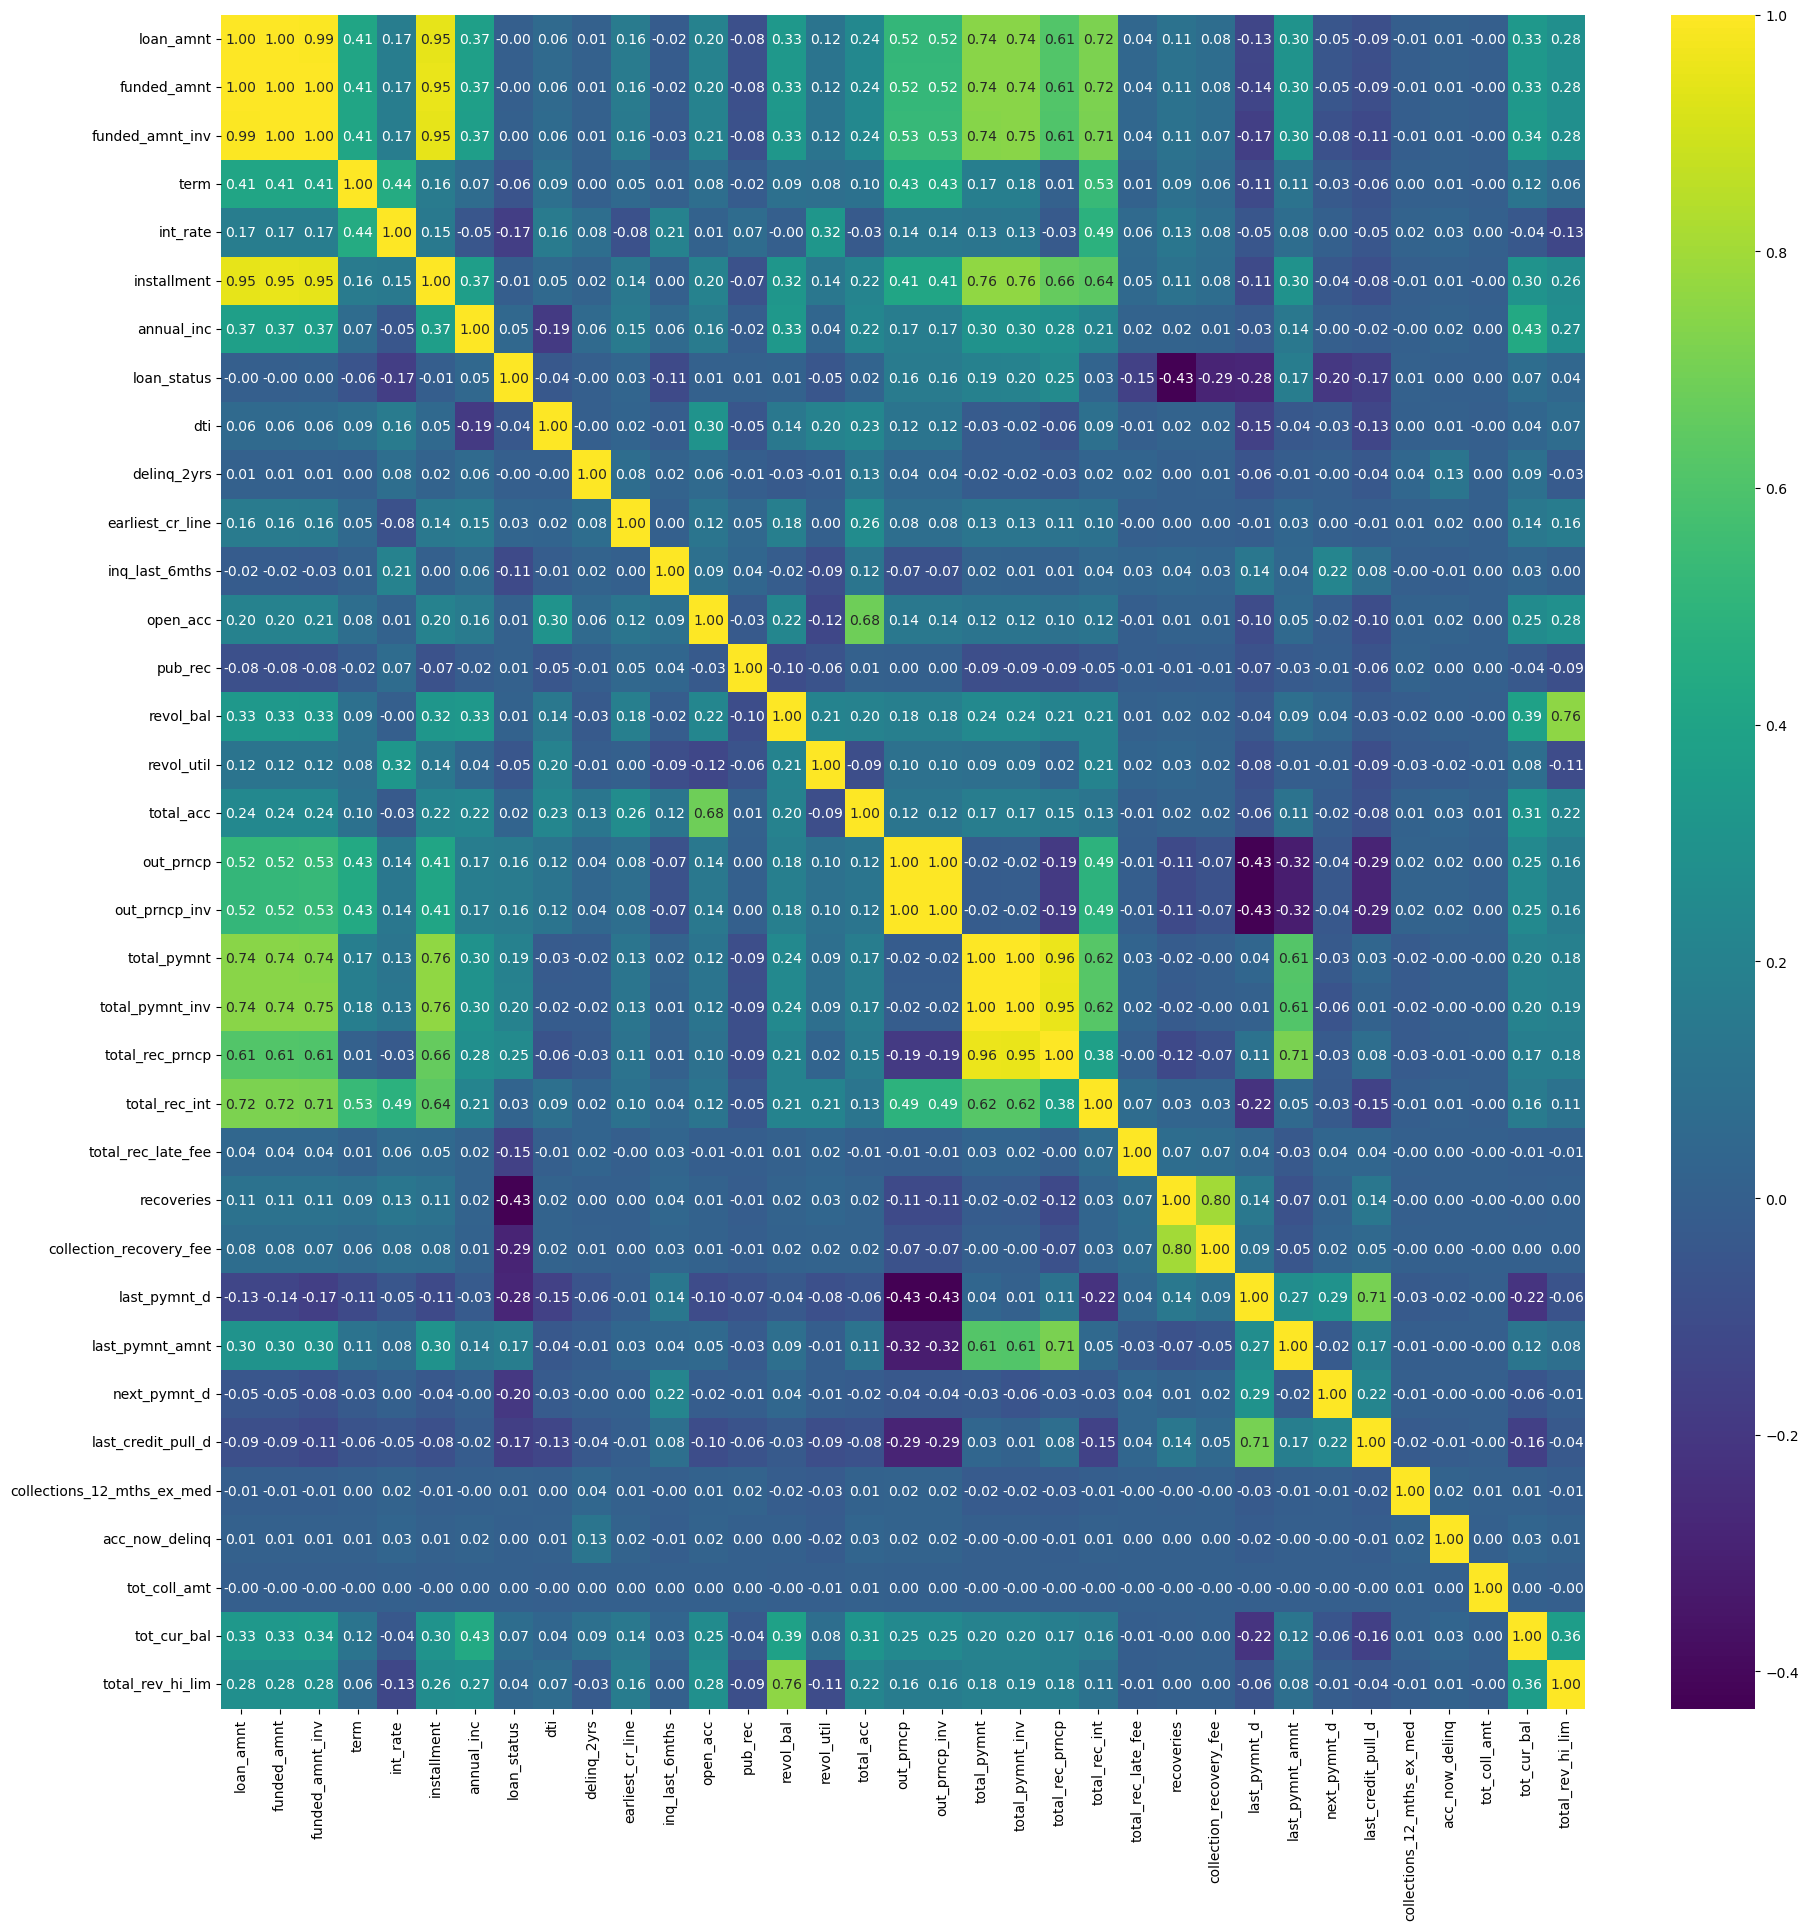

In [228]:
plt.figure(figsize=(22,22)) 
sns.heatmap(df_clean.corr(), cmap='viridis', annot=True, fmt='.2f') 
plt.show()

Dari correlation heatmap, terdapat beberapa fitur yang memiliki nilai korelasi yang tinggi terhadap loan_status. Untuk mencegah terjadinya multikolinieritas, beberapa fitur tersebut akan dihilangkan dengan menggunakan nilai 0.7 sebagai ambang batas.

### Drop Fitur yang Berkorelasi Tinggi

In [229]:
cor_matrix = df_clean.corr().abs() 
high = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool)) 
hicorr_drop_list = [column for column in high.columns if any(high[column] > 0.7)]
hicorr_drop_list

['funded_amnt',
 'funded_amnt_inv',
 'installment',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'total_rev_hi_lim']

In [230]:
df_clean.drop(hicorr_drop_list, axis = 1, inplace=True)

In [231]:
df_clean.corr()['loan_status'].sort_values()

recoveries                   -0.426263
last_pymnt_d                 -0.275550
next_pymnt_d                 -0.197946
int_rate                     -0.172282
total_rec_late_fee           -0.154241
inq_last_6mths               -0.110241
term                         -0.058383
revol_util                   -0.047981
dti                          -0.043026
loan_amnt                    -0.004195
delinq_2yrs                  -0.002164
acc_now_delinq                0.000468
tot_coll_amt                  0.001489
collections_12_mths_ex_med    0.005177
open_acc                      0.008081
pub_rec                       0.009916
revol_bal                     0.011045
total_acc                     0.024612
earliest_cr_line              0.032705
annual_inc                    0.048963
tot_cur_bal                   0.071906
out_prncp                     0.157245
loan_status                   1.000000
Name: loan_status, dtype: float64

## Business Insight

In [232]:
df_eda = df.copy()

In [233]:
df_eda['risk'] = np.where((df_eda['loan_status'] =='Charged Off') | (df_eda['loan_status'] =='Default') | (df_eda['loan_status'] =='Late (31-120 days)') | (df_eda['loan_status'] =='Late (16-30 days)') | (df_eda['loan_status'] =='Does not meet the credit policy. Status:Charged Off'),'Bad Risk','Good Risk')

#### Jumlah Pengajuan berdasarkan Loan Status

In [234]:
loan_by_status = df_eda.groupby('loan_status').size().reset_index() 
loan_by_status.columns = ['Target','Total Applicants'] 
loan_by_status['%'] = round(loan_by_status['Total Applicants']*100/sum(loan_by_status['Total Applicants']),2) 
loan_by_status.sort_values(by='Total Applicants', ascending=False).style.background_gradient(cmap='Greens')

,Target,Total Applicants,%
1,Current,224226,48.090000
5,Fully Paid,184739,39.620000
0,Charged Off,42475,9.110000
8,Late (31-120 days),6900,1.480000
6,In Grace Period,3146,0.670000
4,Does not meet the credit policy. Status:Fully Paid,1988,0.430000
7,Late (16-30 days),1218,0.260000
2,Default,832,0.180000
3,Does not meet the credit policy. Status:Charged Off,761,0.160000


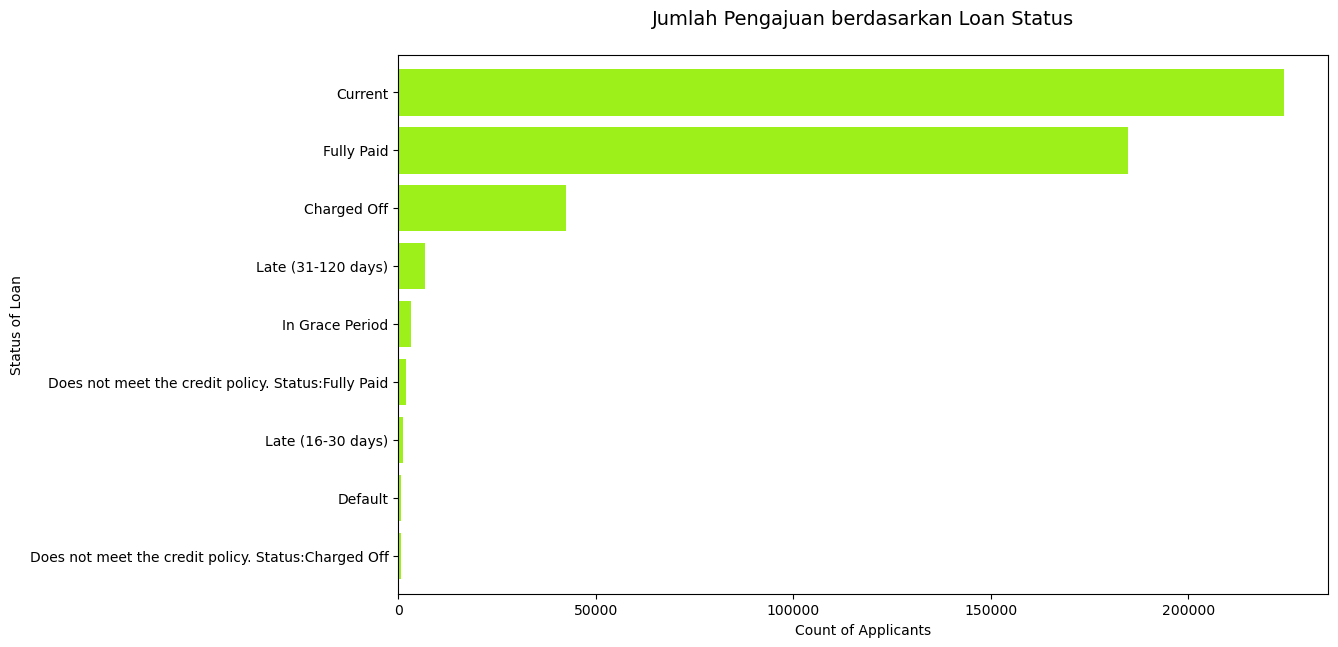

In [235]:
loan_status_counts = df_eda['loan_status'].value_counts().sort_values(ascending=True)

# Membuat plot
fig = plt.figure(figsize=(12, 7)) 
loan_status_counts.plot(kind='barh', color='#9ef01a', width=0.8) 

# Menambahkan judul dan label sumbu
plt.title('Jumlah Pengajuan berdasarkan Loan Status\n', fontsize=14) 
plt.ylabel('Status of Loan') 
plt.xlabel('Count of Applicants')

# Menampilkan plot
plt.show()


Terdapat sekitar 48% atau setara dengan sekitar 224.226 pemohon dengan loan_status Current diikuti dengan loan_status Fully Paid sebesar 39,6% atau setara dengan 184.739 pemohon.

In [236]:
loan_risk = df_eda.groupby('risk').size().reset_index() 
loan_risk.columns = ['Target','Total'] 
loan_risk['%'] = round(loan_risk['Total']*100/sum(loan_risk['Total']),2) 
loan_risk.sort_values(by='Total', ascending=False)

,Target,Total,%
1,Good Risk,414099,88.81
0,Bad Risk,52186,11.19


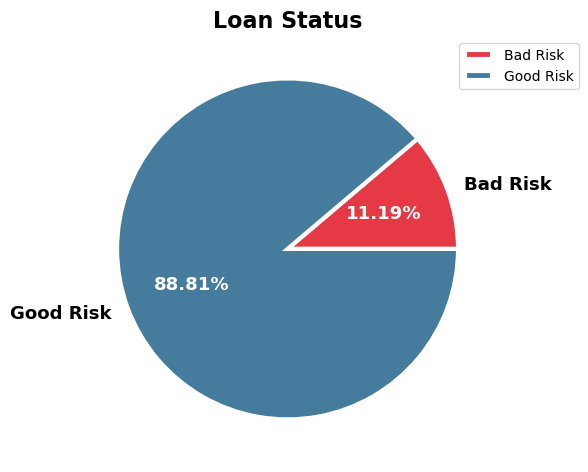

In [237]:
labels = ['Bad Risk', 'Good Risk'] 
colors = ["#e63946", "#457b9d"]  

sns.set_palette(sns.color_palette(colors)) 

# Buat plot pie yang baru
fig, ax = plt.subplots(figsize=(6, 6)) 
patches, texts, pcts = plt.pie(loan_risk['Total'], labels=labels, autopct='%.2f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, textprops={'fontsize': 13, 'fontweight': 'bold'}) 

plt.setp(pcts, color='white', fontweight=600) 
plt.setp(texts, fontweight=600)

plt.legend(labels, loc='upper right', bbox_to_anchor=(1.2, 1)) 

ax.set_title('Loan Status', fontsize=16, fontweight='bold', color='000000')

plt.tight_layout()
plt.show()

Terlihat bahwa dataset ini sangat tidak seimbang dengan 11% kelas minoritas, yaitu Bad Risk dan 88% majority class yaitu Good Risk

Risk Status by Term

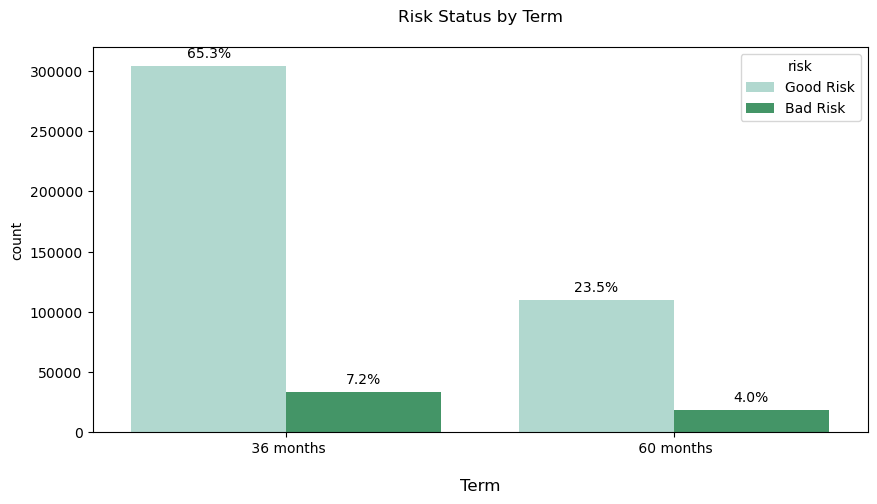

In [238]:
plt.figure(figsize=(10,5))
fig = sns.countplot(data=df_eda, x='term', hue='risk', palette='BuGn')
plt.title('Risk Status by Term\n', fontsize=12)
plt.xlabel('\nTerm', fontsize=12)

# Menghitung total untuk setiap grup
total = len(df_eda['term'])

# Menambahkan persentase di atas setiap bar
for p in fig.patches:
    height = p.get_height()
    fig.annotate(f'{height/total:.1%}', 
                 (p.get_x() + p.get_width() / 2., height), 
                 ha='center', va='center', 
                 xytext=(0, 9), 
                 textcoords='offset points')

plt.show()

- Jangka waktu pinjaman memberi tahu kami tentang jumlah pembayaran pinjaman.
- Hanya ada dua jenis jangka waktu pinjaman, yaitu 36 bulan atau 60 bulan. Sebagian besar pinjaman (72.5%) memiliki jangka waktu yang lebih pendek, yaitu 36 bulan.
- Pinjaman dengan jangka waktu 36 bulan memiliki kemungkinan dua kali lipat lebih besar untuk mengalami risiko kredit macet dibandingkan pinjaman dengan jangka waktu 60 bulan.

Risk Status by Home Ownership

In [239]:
df_eda['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [240]:
def cat_owns(row):
    ownership = row['home_ownership']
    if ownership in ['MORTGAGE', 'RENT', 'OWN']:
        return ownership
    return 'OTHERS'

df_eda['home_ownership'] = df_eda.apply(cat_owns, axis=1)

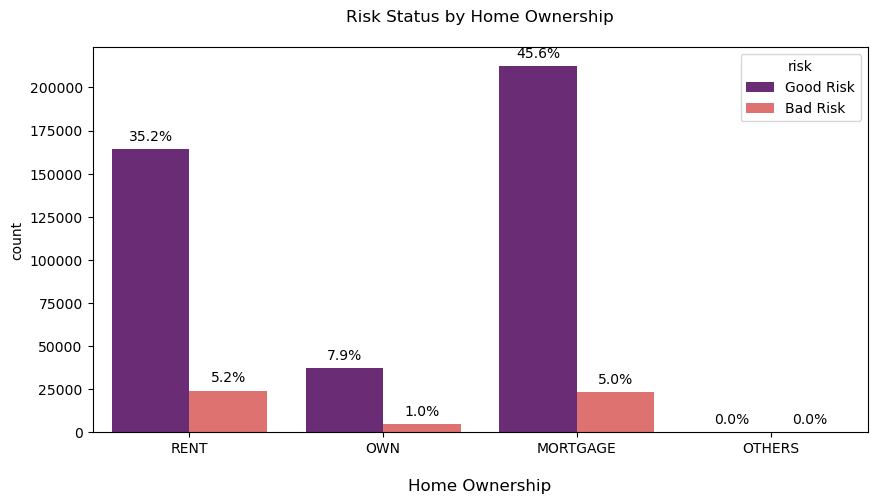

In [241]:
plt.figure(figsize=(10,5))
fig = sns.countplot(data=df_eda, x='home_ownership', hue='risk', palette='magma')
plt.title('Risk Status by Home Ownership\n', fontsize=12)
plt.xlabel('\nHome Ownership', fontsize=12)

# Menghitung total untuk setiap grup
total = len(df_eda['home_ownership'])

# Menambahkan persentase di atas setiap bar
for p in fig.patches:
    height = p.get_height()
    fig.annotate(f'{height/total:.1%}', 
                 (p.get_x() + p.get_width() / 2., height), 
                 ha='center', va='center', 
                 xytext=(0, 9), 
                 textcoords='offset points')

plt.show()

- home_ownership adalah kategori yang disediakan oleh pemohon saat pendaftaran.
- Sebagian besar pemohon memiliki cicilan yang sedang berjalan (51.6%) atau saat ini sedang menyewa rumah (40.4%).
- Pemohon yang memiliki cicilan rumah atau sedang menyewa rumah memiliki kemungkinan risiko kredit macet yang lebih tinggi.


Loan Status by purpose

In [242]:
df_eda['purpose'].value_counts()

debt_consolidation    274195
credit_card           104157
home_improvement       26537
other                  23690
major_purchase          9828
small_business          7013
car                     5397
medical                 4602
moving                  2994
vacation                2487
wedding                 2343
house                   2269
educational              422
renewable_energy         351
Name: purpose, dtype: int64

In [243]:
# def categorize_purpose(purpose):
#     if purpose == 'debt_consolidation':
#         return 'debt_consolidation'
#     elif purpose == 'credit_card':
#         return 'credit_card'
#     elif purpose == 'home_improvement' or purpose == 'car' or purpose == 'house':
#         return 'Object_spending'
#     elif purpose == 'small_business' or purpose == 'medical' or purpose == 'moving' or purpose == 'vacation' or purpose == 'wedding' or purpose == 'educational' or purpose == 'renewable_energy':
#         return 'Life_spending'
#     else:
#         return 'other'

# df_eda['purpose'] = df_eda['purpose'].apply(categorize_purpose)

df_eda['purpose'] = np.select([(df_eda['purpose'] == 'debt_consolidation'),
                               (df_eda['purpose'] == 'credit_card'),
                               (df_eda['purpose'] == 'other'),
                               (df_eda['purpose'] == 'major_purchase'),
                               (df_eda['purpose'].str.contains('home|car|house')),
                               (df_eda['purpose'].str.contains('small|medic|moving|vaca|wedd|educa|renew'))],
                               ['debt_consolidation','credit_card','other','major_purchase','Object_spending','Life_spending'])

df_pr = df_eda[(df_eda['risk'] == 'Bad Risk')]
df_pr = df_pr.groupby(['purpose'])['member_id'].agg(['count']).reset_index()
df_pr.columns = ['Reason', 'Bad Risk']
df_pr['Perc'] = round((df_pr['Bad Risk']/len(df_clean))*100,3)
df_pr = df_pr.sort_values('Bad Risk', ascending=False).reset_index(drop=True)
df_pr

,Reason,Bad Risk,Perc
0,debt_consolidation,31836,6.828
1,credit_card,9200,1.973
2,Object_spending,3482,0.747
3,Life_spending,3367,0.722
4,other,3339,0.716
5,major_purchase,962,0.206


Text(0.5, 0, '\nPurpose')

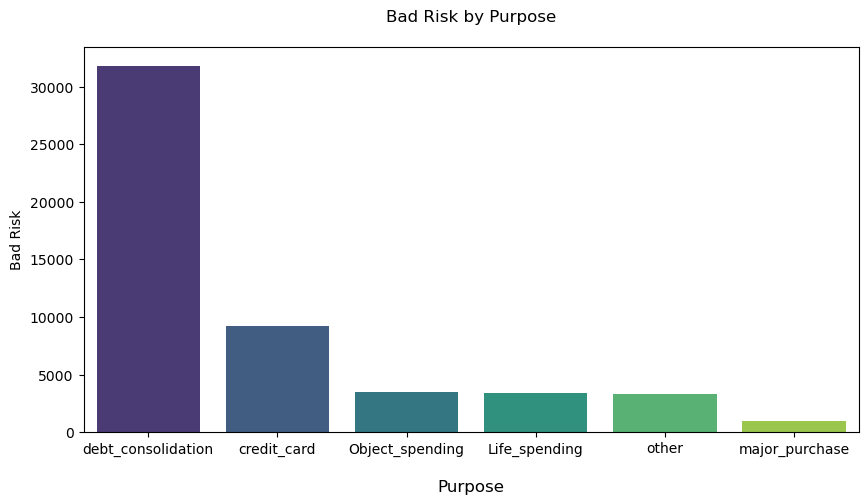

In [244]:
plt.figure(figsize=(10,5))
fig = sns.barplot(data = df_pr, x='Reason', y='Bad Risk', palette='viridis')
plt.title('Bad Risk by Purpose\n', fontsize=12)
plt.xlabel('\nPurpose', fontsize=12)

- Sebagian besar nasabah yang memiliki tipe risiko macet berada di debt_consolidation 6,8%.
- Yang kedua adalah kartu_kredit, Hal ini menunjukkan bahwa karena alasan hutang, nasabah lebih cenderung menjadi tipe nasabah yang Macet

## Feature Selection

In [245]:
df_clean.columns.tolist()

['loan_amnt',
 'term',
 'int_rate',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'loan_status',
 'purpose',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'total_rec_late_fee',
 'recoveries',
 'last_pymnt_d',
 'next_pymnt_d',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal']

In [246]:
df_sel = df_clean.copy()

In [247]:
def woe(raw, feature_name):
    # probability analysis
    feature_name = raw.groupby(feature_name).agg(num_observation=('loan_status','count'),
                                                good_loan_prob=('loan_status','mean')).reset_index()
    
    # find the feature proportion
    feature_name['feat_proportion'] = feature_name['num_observation']/(feature_name['num_observation'].sum())
    
    # find number of approved loan behavior
    feature_name['num_loan_approve'] = feature_name['feat_proportion'] * feature_name['num_observation']

    # find number of declined loan behavior
    feature_name['num_loan_decline'] = (1-feature_name['feat_proportion']) * feature_name['num_observation']

    # find approved loan proportion
    feature_name['prop_loan_approve'] = feature_name['num_loan_approve'] / (feature_name['num_loan_approve'].sum())

    # find declined loan proportion
    feature_name['prop_loan_decline'] = feature_name['num_loan_decline'] / (feature_name['num_loan_decline'].sum())

    # calculate weight of evidence
    feature_name['weight_of_evidence'] = np.log(feature_name['prop_loan_approve'] / feature_name['prop_loan_decline'])

    # sort values by weight of evidence
    feature_name = feature_name.sort_values('weight_of_evidence').reset_index(drop=True)
    
    # calculate information value
    feature_name['information_value'] = (feature_name['prop_loan_approve']-feature_name['prop_loan_decline']) * feature_name['weight_of_evidence']
    feature_name['information_value'] = feature_name['information_value'].sum()

    #Show
    feature_name = feature_name.drop(['feat_proportion','num_loan_approve','num_loan_decline','prop_loan_approve','prop_loan_decline'],axis = 1)

    return feature_name

### Categorical Features

In [248]:
df_clean.describe(include = 'O')

,grade,emp_length,home_ownership,verification_status,purpose,initial_list_status
count,466285,466285,466285,466285,466285,466285
unique,7,11,6,3,14,2
top,B,10+ years,MORTGAGE,Verified,debt_consolidation,f
freq,136929,171057,235875,168055,274195,303005


In [249]:
woe(df_sel,'grade')

,grade,num_observation,good_loan_prob,weight_of_evidence,information_value
0,G,3322,0.679711,-3.660567,0.292639
1,F,13229,0.741401,-2.257091,0.292639
2,E,35757,0.789775,-1.211753,0.292639
3,A,74867,0.959328,-0.377550,0.292639
4,D,76888,0.835787,-0.345737,0.292639
5,C,125293,0.878493,0.275309,0.292639
6,B,136929,0.917643,0.398836,0.292639


In [250]:
woe(df_sel,'emp_length')

,emp_length,num_observation,good_loan_prob,weight_of_evidence,information_value
0,9 years,17888,0.881093,-1.682895,1.030304
1,8 years,22395,0.884349,-1.448086,1.030304
2,6 years,26112,0.876800,-1.286119,1.030304
3,7 years,26180,0.883613,-1.283364,1.030304
4,4 years,28023,0.882240,-1.211138,1.030304
5,1 year,29622,0.877017,-1.151991,1.030304
6,5 years,30774,0.878696,-1.111196,1.030304
7,< 1 year,36265,0.867944,-0.934325,1.030304
8,3 years,36596,0.882446,-0.924469,1.030304
9,2 years,41373,0.881251,-0.790600,1.030304


In [251]:
df_sel['home_ownership'] = np.where(df_sel['home_ownership']=='ANY','OTHER',
                       np.where(df_sel['home_ownership']=='NONE','OTHER',df_sel['home_ownership']))
     

woe(df_sel,'home_ownership')

,home_ownership,num_observation,good_loan_prob,weight_of_evidence,information_value
0,OTHER,233,0.669528,-7.308027,0.311741
1,OWN,41704,0.885359,-2.027519,0.311741
2,RENT,188473,0.866501,-0.095003,0.311741
3,MORTGAGE,235875,0.897594,0.316429,0.311741


In [252]:
woe(df_sel,'verification_status')

,verification_status,num_observation,good_loan_prob,weight_of_evidence,information_value
0,Not Verified,148237,0.895262,-0.075220,0.007663
1,Source Verified,149993,0.891342,-0.057908,0.007663
2,Verified,168055,0.867008,0.114596,0.007663


In [253]:
woe(df_sel,'purpose')

,purpose,num_observation,good_loan_prob,weight_of_evidence,information_value
0,renewable_energy,351,0.840456,-6.796087,1.409257
1,educational,422,0.637441,-6.611715,1.409257
2,house,2269,0.843543,-4.925653,1.409257
3,wedding,2343,0.860009,-4.893401,1.409257
4,vacation,2487,0.872135,-4.833445,1.409257
5,moving,2994,0.834335,-4.646819,1.409257
6,medical,4602,0.856584,-4.213461,1.409257
7,car,5397,0.900130,-4.052385,1.409257
8,small_business,7013,0.766862,-3.786951,1.409257
9,major_purchase,9828,0.891941,-3.443333,1.409257


In [254]:
woe(df_sel,'initial_list_status')

,initial_list_status,num_observation,good_loan_prob,weight_of_evidence,information_value
0,w,163280,0.907741,-0.798355,0.340013
1,f,303005,0.870926,0.438211,0.340013


### Numerical Features

In [255]:
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,466285.0,14317.277577,8286.509164,500.00,8000.00,12000.00,20000.00,35000.00
term,466285.0,42.605334,10.719040,36.00,36.00,36.00,60.00,60.00
int_rate,466285.0,13.829236,4.357587,5.42,10.99,13.66,16.49,26.06
annual_inc,466285.0,73277.293307,54963.341145,1896.00,45000.00,63000.00,88953.00,7500000.00
loan_status,466285.0,0.883818,0.320444,0.00,1.00,1.00,1.00,1.00
dti,466285.0,17.218758,7.851121,0.00,11.36,16.87,22.78,39.99
delinq_2yrs,466285.0,0.284661,0.797343,0.00,0.00,0.00,0.00,29.00
earliest_cr_line,466285.0,218.480348,93.972277,-633.00,162.00,204.00,264.00,566.00
inq_last_6mths,466285.0,0.804695,1.091583,0.00,0.00,0.00,1.00,33.00
open_acc,466285.0,11.186995,4.987380,0.00,8.00,10.00,14.00,84.00


In [256]:
df_sel['loan_amnt_fs'] = pd.cut(df_sel['loan_amnt'], 5)
woe(df_sel,'loan_amnt_fs')

,loan_amnt_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(28100.0, 35000.0]",34906,0.875867,-1.391294,0.249414
1,"(21200.0, 28100.0]",52172,0.882504,-0.948559,0.249414
2,"(465.5, 7400.0]",103603,0.884096,-0.129926,0.249414
3,"(14300.0, 21200.0]",118918,0.883458,0.051086,0.249414
4,"(7400.0, 14300.0]",156686,0.886116,0.442000,0.249414


In [257]:
woe(df_sel,'term')

,term,num_observation,good_loan_prob,weight_of_evidence,information_value
0,60,128332,0.853458,-1.378129,0.72423
1,36,337953,0.895346,0.558444,0.72423


In [258]:
df_sel['int_rate_fs'] = pd.cut(df_sel['int_rate'], 5)
woe(df_sel,'int_rate_fs')

,int_rate_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(21.932, 26.06]",23189,0.761870,-1.899708,0.284226
1,"(17.804, 21.932]",57785,0.809241,-0.905362,0.284226
2,"(5.399, 9.548]",83978,0.959859,-0.465268,0.284226
3,"(13.676, 17.804]",147973,0.860704,0.284398,0.284226
4,"(9.548, 13.676]",153360,0.911020,0.337225,0.284226


In [259]:
df_sel['annual_inc_fs'] = pd.cut(df_sel['annual_inc'], 5)
woe(df_sel,'annual_inc_fs')

,annual_inc_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(3001137.6, 4500758.4]",1,1.000000,-22.467463,10.68265
1,"(4500758.4, 6000379.2]",4,1.000000,-21.081162,10.68265
2,"(6000379.2, 7500000.0]",4,1.000000,-21.081162,10.68265
3,"(1501516.8, 3001137.6]",10,1.000000,-20.164858,10.68265
4,"(-5602.104, 1501516.8]",466266,0.883813,0.693160,10.68265


In [260]:
df_sel['dti_fs'] = pd.cut(df_sel['dti'], 5)
woe(df_sel,'dti_fs')

,dti_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(31.992, 39.99]",16407,0.864814,-2.306884,0.293918
1,"(-0.04, 7.998]",59690,0.901642,-0.914269,0.293918
2,"(23.994, 31.992]",80361,0.863827,-0.564727,0.293918
3,"(7.998, 15.996]",154680,0.897110,0.304006,0.293918
4,"(15.996, 23.994]",155147,0.876072,0.308521,0.293918


In [261]:
df_sel['delinq_2yrs_fs'] = np.where(df_sel['delinq_2yrs'] > 3, 3,
                                 np.where(df_sel['delinq_2yrs'] == 2, 2,
                                 np.where(df_sel['delinq_2yrs'] == 1,1,0)))
woe(df_sel,'delinq_2yrs_fs')

,delinq_2yrs_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,3,5084,0.881786,-5.406375,2.038543
1,2,16310,0.880135,-4.216053,2.038543
2,1,56224,0.885654,-2.885602,2.038543
3,0,388667,0.883733,0.712284,2.038543


In [262]:
df_sel['earliest_cr_line_fs'] = pd.cut(df_sel['earliest_cr_line'], 5)
woe(df_sel,'earliest_cr_line_fs')

,earliest_cr_line_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(-393.2, -153.4]",4,1.000000,-12.828953,2.085151
1,"(-634.199, -393.2]",1165,0.864378,-7.152278,2.085151
2,"(-153.4, 86.4]",7464,0.871651,-5.281272,2.085151
3,"(326.2, 566.0]",54388,0.903766,-3.187333,2.085151
4,"(86.4, 326.2]",403264,0.881408,0.693420,2.085151


In [263]:
df_sel['inq_last_6mths_fs'] = np.where(df_sel['inq_last_6mths'] == 0,0,
                                    np.where((df_sel['inq_last_6mths'] > 0)&(df_sel['inq_last_6mths'] <=3),1,
                                    np.where((df_sel['inq_last_6mths']>3)&(df_sel['inq_last_6mths']<=6),2,
                                    np.where((df_sel['inq_last_6mths']>6)&(df_sel['inq_last_6mths']<=9),3,4))))

# show
woe(df_sel,'inq_last_6mths_fs')

,inq_last_6mths_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,4,95,0.000000,-8.409390,0.188408
1,3,367,0.147139,-7.057322,0.188408
2,2,11197,0.737162,-3.615764,0.188408
3,1,213099,0.869033,-0.083286,0.188408
4,0,241527,0.905129,0.161038,0.188408


In [264]:
df_sel['open_acc_fs'] = pd.cut(df_sel['open_acc'], 5)
woe(df_sel,'open_acc_fs')

,open_acc_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(67.2, 84.0]",4,0.500000,-12.858748,1.830395
1,"(50.4, 67.2]",22,1.000000,-11.153962,1.830395
2,"(33.6, 50.4]",898,0.886414,-7.442954,1.830395
3,"(16.8, 33.6]",61622,0.886907,-3.074535,1.830395
4,"(-0.084, 16.8]",403739,0.883338,0.672367,1.830395


In [265]:
df_sel['pub_rec_fs'] = pd.cut(df_sel['pub_rec'], 5)
woe(df_sel,'pub_rec_fs')

,pub_rec_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(25.2, 37.8]",1,1.000000,-22.703865,10.838649
1,"(37.8, 50.4]",2,1.000000,-22.010715,10.838649
2,"(50.4, 63.0]",2,1.000000,-22.010715,10.838649
3,"(12.6, 25.2]",10,1.000000,-20.401260,10.838649
4,"(-0.063, 12.6]",466270,0.883814,0.693155,10.838649


In [266]:
df_sel['revol_bal_fs'] = np.where((df_sel['revol_bal']>=0)&(df_sel['revol_bal']<=5000),0,
                               np.where((df_sel['revol_bal']>5000)&(df_sel['revol_bal']<=10000),1,
                               np.where((df_sel['revol_bal']>10000)&(df_sel['revol_bal']<=15000),2,3)))

# show
woe(df_sel,'revol_bal_fs')

,revol_bal_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,0,82590,0.875239,-0.576520,0.197731
1,2,88805,0.882011,-0.487635,0.197731
2,1,115537,0.880480,-0.151038,0.197731
3,3,179353,0.890813,0.489550,0.197731


In [267]:
df_sel['revol_util_fs'] = np.where((df_sel['revol_util']>=0)&(df_sel['revol_util']<=20),0,
                                np.where((df_sel['revol_util']>20)&(df_sel['revol_util']<=40),1,
                                np.where((df_sel['revol_util']>40)&(df_sel['revol_util']<=60),2,
                                np.where((df_sel['revol_util']>60)&(df_sel['revol_util']<=80),3,4))))

# show
woe(df_sel,'revol_util_fs')

,revol_util_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,0,37402,0.907438,-1.220141,0.157668
1,1,83492,0.901679,-0.303424,0.157668
2,4,84062,0.859449,-0.295130,0.157668
3,2,129737,0.889114,0.266088,0.157668
4,3,131592,0.876117,0.285812,0.157668


In [268]:
df_sel['total_acc_fs'] = pd.cut(df_sel['total_acc'], 5)
woe(df_sel,'total_acc_fs')

,total_acc_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(125.0, 156.0]",2,1.000000,-12.936344,1.03453
1,"(94.0, 125.0]",28,0.964286,-10.297231,1.03453
2,"(63.0, 94.0]",1221,0.904177,-6.519448,1.03453
3,"(32.0, 63.0]",107819,0.891911,-1.778323,1.03453
4,"(0.845, 32.0]",357215,0.881298,0.609405,1.03453


In [269]:
df_sel['out_prncp_fs'] = np.where((df_sel['out_prncp']>=0)&(df_sel['out_prncp']<=1000),0,
                               np.where((df_sel['out_prncp']>1000)&(df_sel['out_prncp']<=10000),1,
                               np.where((df_sel['out_prncp']>10000)&(df_sel['out_prncp']<=17000),2,3)))

# show
woe(df_sel,'out_prncp_fs')

,out_prncp_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,3,28933,0.948225,-2.216759,0.587279
1,2,53928,0.956887,-1.535243,0.587279
2,1,142293,0.965585,-0.323834,0.587279
3,0,241131,0.811497,0.567552,0.587279


In [270]:
df_sel['total_rec_late_fee_fs'] = np.where(df_sel['total_rec_late_fee']==0,0,1)

# show
woe(df_sel,'total_rec_late_fee_fs')

,total_rec_late_fee_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,1,10678,0.507024,-6.814292,3.749324
1,0,455607,0.892649,0.692598,3.749324


In [271]:
df_sel['recoveries_fs'] = pd.cut(df_sel['recoveries'], 5)
woe(df_sel,'recoveries_fs')

,recoveries_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(26816.216, 33520.27]",5,0.000000,-17.866686,7.407134
1,"(20112.162, 26816.216]",13,0.000000,-16.911158,7.407134
2,"(13408.108, 20112.162]",45,0.000000,-15.669376,7.407134
3,"(6704.054, 13408.108]",315,0.000000,-13.722887,7.407134
4,"(-33.52, 6704.054]",465907,0.884535,0.693264,7.407134


In [272]:
df_sel['last_pymnt_d_fs'] = np.where(df_sel['last_pymnt_d']==2,0,
                                  np.where((df_sel['last_pymnt_d']>2)&(df_sel['last_pymnt_d']<=4),1,
                                  np.where((df_sel['last_pymnt_d']>4)&(df_sel['last_pymnt_d']<=6),2,
                                  np.where((df_sel['last_pymnt_d']>6)&(df_sel['last_pymnt_d']<=12),3,4))))
                                           
# show
woe(df_sel,'last_pymnt_d_fs')

,last_pymnt_d_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,2,21452,0.793259,-2.047872,0.374923
1,3,61476,0.790487,-0.900759,0.374923
2,1,71317,0.945413,-0.727661,0.374923
3,4,132044,0.759845,0.055282,0.374923
4,0,179996,0.993028,0.519942,0.374923


In [273]:
df_sel['collections_12_mths_ex_med_fs'] = pd.cut(df_sel['collections_12_mths_ex_med'], 5)
woe(df_sel,'collections_12_mths_ex_med_fs')

,collections_12_mths_ex_med_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(12.0, 16.0]",1,1.000000,-24.02565,12.186145
1,"(16.0, 20.0]",1,1.000000,-24.02565,12.186145
2,"(4.0, 8.0]",2,1.000000,-23.33250,12.186145
3,"(-0.02, 4.0]",466281,0.883817,0.69315,12.186145
4,"(8.0, 12.0]",0,NaN,NaN,12.186145


In [274]:
df_sel['acc_now_delinq_fs'] = pd.cut(df_sel['acc_now_delinq'], 5)
woe(df_sel,'acc_now_delinq_fs')

,acc_now_delinq_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(4.0, 5.0]",2,0.500000,-20.027192,8.645917
1,"(3.0, 4.0]",4,1.000000,-19.334041,8.645917
2,"(2.0, 3.0]",11,0.818182,-18.322425,8.645917
3,"(1.0, 2.0]",92,0.902174,-16.198358,8.645917
4,"(-0.005, 1.0]",466176,0.883816,0.693179,8.645917


In [275]:
df_sel['tot_coll_amt_fs'] = pd.cut(df_sel['tot_coll_amt'], 5)
woe(df_sel,'tot_coll_amt_fs')

,tot_coll_amt_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(7322036.0, 9152545.0]",1,1.000000,-25.411953,13.05255
1,"(-9152.545, 1830509.0]",466284,0.883818,0.693147,13.05255
2,"(1830509.0, 3661018.0]",0,NaN,NaN,13.05255
3,"(3661018.0, 5491527.0]",0,NaN,NaN,13.05255
4,"(5491527.0, 7322036.0]",0,NaN,NaN,13.05255


In [276]:
df_sel['tot_cur_bal_fs'] = pd.cut(df_sel['tot_cur_bal'], 5)
woe(df_sel,'tot_cur_bal_fs')

,tot_cur_bal_fs,num_observation,good_loan_prob,weight_of_evidence,information_value
0,"(6400062.4, 8000078.0]",1,1.000000,-20.624183,8.44193
1,"(3200031.2, 4800046.8]",11,0.909091,-18.226266,8.44193
2,"(1600015.6, 3200031.2]",108,0.935185,-15.941822,8.44193
3,"(-8000.078, 1600015.6]",466165,0.883805,0.693170,8.44193
4,"(4800046.8, 6400062.4]",0,NaN,NaN,8.44193


Fitur yang akan kami hilangkan karena memiliki:
- Value <0,02 (prediksi yang tidak berguna)
- value > 0.5 (prediksi yang mencurigakan)
- Fitur yang tidak masuk akal untuk dibuang

In [277]:
drop_list = ['emp_length','verification_status', 'purpose', 'term','annual_inc', 'delinq_2yrs','earliest_cr_line', 'total_acc','open_acc', 'pub_rec', 
             'out_prncp', 'total_rec_late_fee','recoveries', 'collections_12_mths_ex_med', 
             'acc_now_delinq','tot_coll_amt','tot_cur_bal']

print(len(drop_list))

17


In [278]:
df_encode = df_clean.copy()

In [279]:
df_encode.drop(['emp_length','verification_status', 'purpose', 'term','annual_inc', 'delinq_2yrs','earliest_cr_line', 'total_acc','open_acc', 'pub_rec', 
             'out_prncp', 'total_rec_late_fee','recoveries', 'collections_12_mths_ex_med', 
             'acc_now_delinq','tot_coll_amt','tot_cur_bal'], axis = 1, inplace=True)

In [280]:
nums = df_encode.select_dtypes(include=np.number).columns
cats = df_encode.select_dtypes(exclude=np.number).columns

### Categorical Feature Encoding

In [281]:
for cat in ['grade', 'home_ownership', 'initial_list_status']:
  onehots = pd.get_dummies(df_clean[cat], prefix=cat)
  df_encode = df_encode.join(onehots)

df_encode = df_encode.drop(columns=['grade', 'home_ownership', 'initial_list_status'], axis =1)
df_encode.head()

,loan_amnt,int_rate,loan_status,dti,inq_last_6mths,revol_bal,revol_util,last_pymnt_d,next_pymnt_d,grade_A,...,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,initial_list_status_f,initial_list_status_w
0,5000,10.65,1,27.65,1.0,13648,83.7,14.0,1.0,0,...,0,0,0,0,0,0,0,1,1,0
1,2500,15.27,0,1.00,5.0,1687,9.4,35.0,1.0,0,...,0,0,0,0,0,0,0,1,1,0
2,2400,15.96,1,8.72,2.0,2956,98.5,21.0,1.0,0,...,0,0,0,0,0,0,0,1,1,0
3,10000,13.49,1,20.00,1.0,5598,21.0,14.0,1.0,0,...,0,0,0,0,0,0,0,1,1,0
4,3000,12.69,1,17.94,0.0,27783,53.9,2.0,1.0,0,...,0,0,0,0,0,0,0,1,1,0


### Numerical Feature Encoding


In [282]:
from sklearn.preprocessing import LabelEncoder

#Label encoding

le = LabelEncoder()

columns = [ 'loan_amnt', 'int_rate', 'loan_status', 'dti', 'inq_last_6mths',
       'revol_bal', 'revol_util', 'last_pymnt_d'
]

for col in columns:
    df_encode[col] = le.fit_transform(df_clean[col])

In [283]:
print("Total Rows :", df_encode.shape[0])
print("Total Features :", df_encode.shape[1])

Total Rows : 466285
Total Features : 24


## Modelling

In [284]:
df_model = df_encode.copy()

### Split Train & Test Data

In [285]:
X = df_model.drop(labels=['loan_status'],axis=1)
y = df_model[['loan_status']]

In [286]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 42)

In [289]:
from sklearn.metrics import confusion_matrix
def plotting_confusion_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', annot_kws={"fontsize":12}, ax=ax)

    # setting title and axis labels
    plt.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('Predicted Labels', fontsize=12)
    ax.set_ylabel('True Labels', fontsize=12)
    ax.set_title('Confusion Matrix ' + title, fontsize=14)
    ax.xaxis.set_ticklabels(['Not Taken', 'Taken'])
    ax.yaxis.set_ticklabels(['Not Taken', 'Taken'])
    plt.show()
def eval_classification(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    # masukin probability
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

### Random Forest

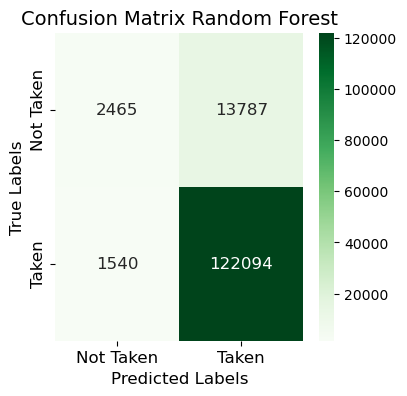

Accuracy (Test Set): 0.89
Precision (Test Set): 0.90
Recall (Test Set): 0.99
F1-Score (Test Set): 0.94
roc_auc (test-proba): 0.85
roc_auc (train-proba): 1.00


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [290]:
model_RF =  RandomForestClassifier(random_state=42)
model_RF.fit(X_train, y_train)

plotting_confusion_matrix(model_RF, X_test, y_test, title='Random Forest')
eval_classification(model_RF, X_train, y_train, X_test, y_test)
model_RF.get_params()

### Decision Tree

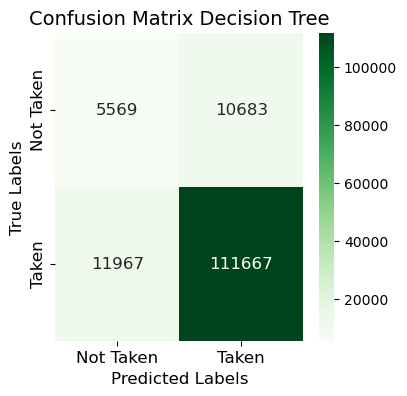

Accuracy (Test Set): 0.84
Precision (Test Set): 0.91
Recall (Test Set): 0.90
F1-Score (Test Set): 0.91
roc_auc (test-proba): 0.62
roc_auc (train-proba): 1.00


<bound method BaseEstimator.get_params of DecisionTreeClassifier(random_state=42)>

In [291]:
model_DT = DecisionTreeClassifier(random_state=42)
model_DT.fit(X_train, y_train)

plotting_confusion_matrix(model_DT, X_test, y_test, title='Decision Tree')
eval_classification(model_DT, X_train, y_train, X_test, y_test)
model_DT.get_params

### Logistic Regression

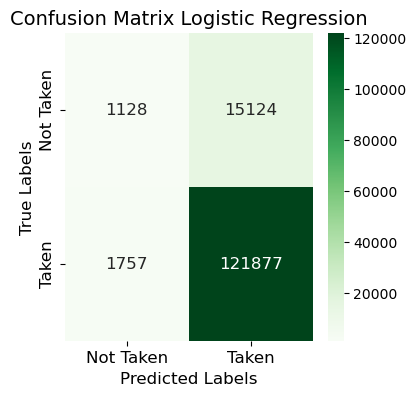

Accuracy (Test Set): 0.88
Precision (Test Set): 0.89
Recall (Test Set): 0.99
F1-Score (Test Set): 0.94
roc_auc (test-proba): 0.59
roc_auc (train-proba): 0.59


<bound method BaseEstimator.get_params of LogisticRegression(random_state=42)>

In [292]:
model_LR = LogisticRegression(random_state=42)
model_LR.fit(X_train, y_train)

plotting_confusion_matrix(model_LR, X_test, y_test, title='Logistic Regression')
eval_classification(model_LR, X_train, y_train, X_test, y_test)
model_LR.get_params

### AdaBoost

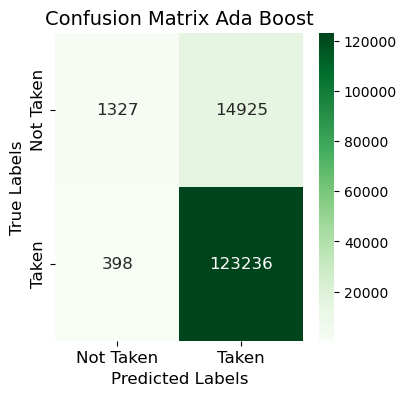

Accuracy (Test Set): 0.89
Precision (Test Set): 0.89
Recall (Test Set): 1.00
F1-Score (Test Set): 0.94
roc_auc (test-proba): 0.85
roc_auc (train-proba): 0.85


<bound method BaseEstimator.get_params of AdaBoostClassifier(random_state=42)>

In [293]:
from sklearn.ensemble import AdaBoostClassifier

model_ADB = AdaBoostClassifier(random_state=42)
model_ADB.fit(X_train, y_train)

plotting_confusion_matrix(model_ADB, X_test, y_test, title='Ada Boost')
eval_classification(model_ADB, X_train, y_train, X_test, y_test)
model_ADB.get_params

### XGBoost

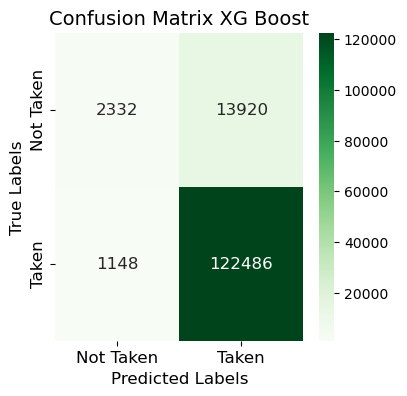

Accuracy (Test Set): 0.89
Precision (Test Set): 0.90
Recall (Test Set): 0.99
F1-Score (Test Set): 0.94
roc_auc (test-proba): 0.86
roc_auc (train-proba): 0.89


<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)>

In [294]:
import xgboost as xgb

# Assuming X_train, X_test, y_train, and y_test are your training and testing data
model_XGB = xgb.XGBClassifier(verbosity=0, random_state=42)
model_XGB.fit(X_train, y_train)

plotting_confusion_matrix(model_XGB, X_test, y_test, title='XG Boost')
eval_classification(model_XGB, X_train, y_train, X_test, y_test)
model_XGB.get_params

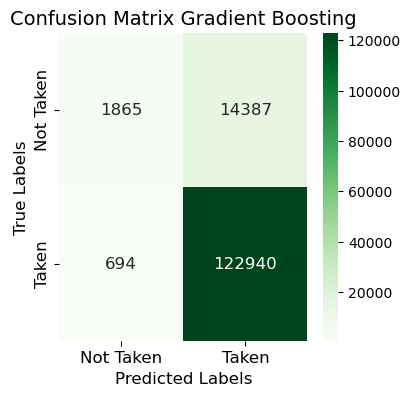

Accuracy (Test Set): 0.89
Precision (Test Set): 0.90
Recall (Test Set): 0.99
F1-Score (Test Set): 0.94
roc_auc (test-proba): 0.86
roc_auc (train-proba): 0.86


{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [309]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

model_grad = GradientBoostingClassifier(random_state=42)
model_grad.fit(X_train, y_train)

plotting_confusion_matrix(model_grad, X_test, y_test, title='Gradient Boosting')
eval_classification(model_grad, X_train, y_train, X_test, y_test)
model_grad.get_params()


[LightGBM] [Info] Number of positive: 288477, number of negative: 37922
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1446
[LightGBM] [Info] Number of data points in the train set: 326399, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.883817 -> initscore=2.029084
[LightGBM] [Info] Start training from score 2.029084


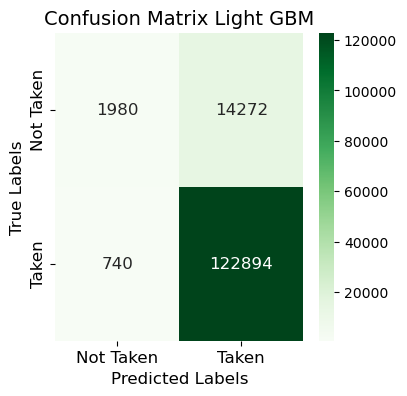

Accuracy (Test Set): 0.89
Precision (Test Set): 0.90
Recall (Test Set): 0.99
F1-Score (Test Set): 0.94
roc_auc (test-proba): 0.86
roc_auc (train-proba): 0.87


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [310]:
import lightgbm as lgb
lg_model  = lgb.LGBMClassifier(random_state=42)
lg_model .fit(X_train, y_train)

plotting_confusion_matrix(lg_model, X_test, y_test, title='Light GBM')
eval_classification(lg_model, X_train, y_train, X_test, y_test)
lg_model.get_params()

### Model Result

In [311]:
def eval(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    precision = round(precision_score(y_test, y_pred), 4)
    recall = round(recall_score(y_test, y_pred), 4)
    f1 = round(f1_score(y_test, y_pred), 4)
    auc_test = round(roc_auc_score(y_test, y_pred_proba[:, 1]), 4)
    auc_train = round(roc_auc_score(y_train, y_pred_proba_train[:, 1]), 4)   
    
    return accuracy, precision, recall, f1, auc_test, auc_train

def score_all_classification(model_list, X_train, y_train, X_test, y_test):
    model_name = ['Random Forest', 'Decision Tree', 'Logistic Regression', 'AdaBoost', 'XGBoost', 'Gradien Boosting', 'LightGBM']
    eval_cols = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC (Test)', 'AUC (Train)']
    
    eval_list = []
    for name, model in zip(model_name, model_list):
        result = eval(model, X_train, y_train, X_test, y_test)
        eval_list.append([name] + list(result))
    df_model = pd.DataFrame(data=eval_list, columns=eval_cols)
    
    return df_model


In [312]:
model_list_base = [model_RF, model_DT, model_LR, model_ADB, model_XGB, model_grad, lg_model]

results = score_all_classification(model_list_base, X_train, y_train, X_test, y_test)
results

,Model,Accuracy,Precision,Recall,F1 Score,AUC (Test),AUC (Train)
0,Random Forest,0.8904,0.8985,0.9875,0.9409,0.8499,1.0000
1,Decision Tree,0.8381,0.9127,0.9032,0.9079,0.6229,1.0000
2,Logistic Regression,0.8793,0.8896,0.9858,0.9352,0.5924,0.5898
3,AdaBoost,0.8905,0.8920,0.9968,0.9415,0.8543,0.8537
4,XGBoost,0.8923,0.8980,0.9907,0.9421,0.8613,0.8858
5,Gradien Boosting,0.8922,0.8952,0.9944,0.9422,0.8580,0.8585
6,LightGBM,0.8927,0.8960,0.9940,0.9424,0.8615,0.8695


## Feature Importance

In [314]:
def show_feature_importance(model, title):
    if type(model).__name__ == 'XGboost':
        feat_importances = pd.Series(model.coef_[0], index=X.columns)
    else:
        feat_importances = pd.Series(model.feature_importances_, index=X.columns)
        
    ax = feat_importances.sort_values(ascending=False).plot(kind='barh', figsize=(10, 8), color='orange')
    ax.invert_yaxis()

    plt.xlabel('Score')
    plt.ylabel('Features')
    plt.title('Feature Importance ' + title)

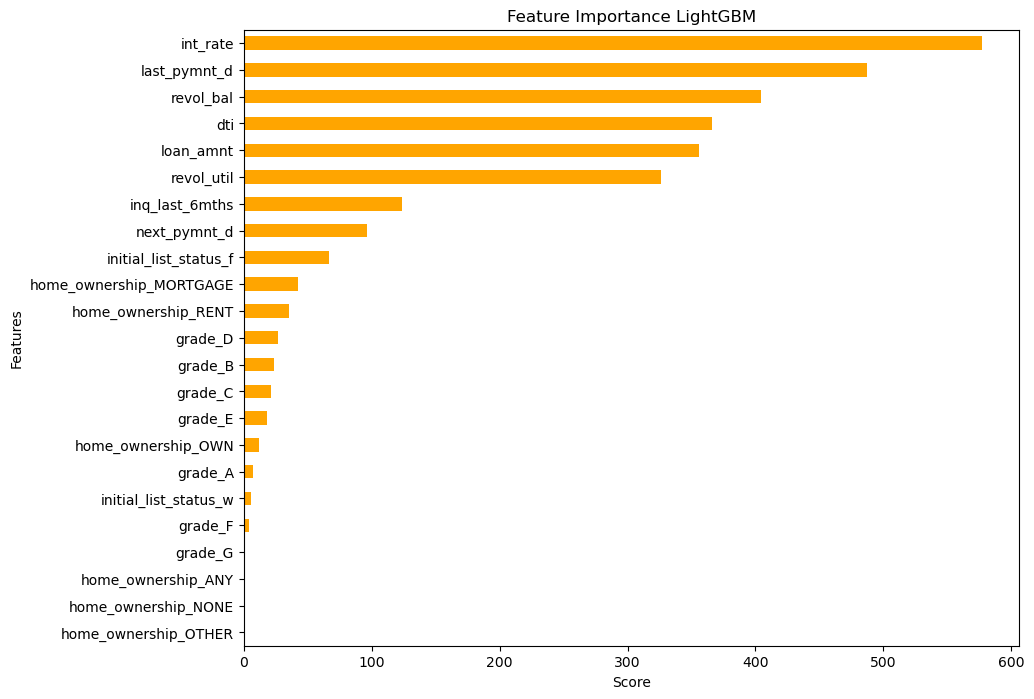

In [321]:
# XGBoost
show_feature_importance(lg_model, title='LightGBM')

## Simulation Business

In [316]:
df_benefit = df_clean.copy()

In [317]:
#define values
ambiguous = ['Current', 'In Grace Period']
good_loan =  ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']

#drop rows that contain ambiguous ending
df_benefit = df_benefit[df_benefit.loan_status.isin(ambiguous) == False]

#create new column to classify ending when 1 equal bad loan, and 0 equal good loan
df_benefit['loan_ending'] = np.where(df_benefit['loan_status'].isin(good_loan), 0, 1)

In [318]:
Total = df_benefit['loan_ending'].count()
Bad = df_benefit[df_benefit['loan_ending'] == 1]['loan_ending'].count()
Good = df_benefit[df_benefit['loan_ending'] == 0]['loan_ending'].count()
PredRate = 0.889
PredBad = round(Bad * PredRate)
PredGood = Bad - PredBad

print('----- Existing -----')
print(f"{'Total_loan :':<15} {Total:<10} {round((Total / Total) * 100, 1):<10}%")
print(f"{'Bad_loan :':<15} {Bad:<10} {round((Bad / Total) * 100, 1):<10}%")
print(f"{'Good_loan :':<15} {Good:<10} {round((Good / Total) * 100, 1):<10}%\n")

print('----- After Modeling -----')
print(f"{'Total_loan :':<15} {Total:<10} {round((Total / Total) * 100, 1):<10}%")
print(f"{'Bad_loan :':<15} {Bad:<10} {round((Bad / Total) * 100, 1):<10}%")
print(f"{'Predicted Bad_loan :':<15} {round(PredBad):<10} {round((PredBad / Bad) * 100, 1):<10}%")
print(f"{'Predicted Good_loan :':<15} {round(PredGood):<10} {round((PredGood / Bad) * 100, 1):<10}%")
print(f"{'Bad_loan After Pred :':<15} {Bad - PredBad:<10} {round(((Bad - PredBad) / Total) * 100, 1):<10}%")
print(f"{'Bad_loan Growth rate :':<15} {round(((Bad - PredBad) / Bad - 1) * 100, 1):<10}%")
print(f"{'Good_loan :':<15} {Good:<10} {round((Good / Total) * 100, 1):<10}%")
print(f"{'Good_loan After Pred :':<15} {Good + PredBad:<10} {round(((Good + PredBad) / Total) * 100, 1):<10}%")
print(f"{'Good_loan Growth rate :':<15} {round(((Good + PredBad) / Good - 1) * 100, 1):<10}%")


----- Existing -----
Total_loan :    466285     100.0     %
Bad_loan :      466285     100.0     %
Good_loan :     0          0.0       %

----- After Modeling -----
Total_loan :    466285     100.0     %
Bad_loan :      466285     100.0     %
Predicted Bad_loan : 414527     88.9      %
Predicted Good_loan : 51758      11.1      %
Bad_loan After Pred : 51758      11.1      %
Bad_loan Growth rate : -88.9     %
Good_loan :     0          0.0       %
Good_loan After Pred : 414527     88.9      %
Good_loan Growth rate : inf       %


In [319]:
Total = df_benefit['loan_ending'].count()
Bad = df_benefit[df_benefit['loan_ending'] == 1]['loan_ending'].count()
Good = df_benefit[df_benefit['loan_ending'] == 0]['loan_ending'].count()
PredRate = 0.889
PredBad = round(Bad * PredRate)
PredGood = Bad - PredBad

print('----- Existing -----')
print(f"{'Total_loan :':<15} {Total:<10} {round((Total / Total) * 100, 1):<10}%")
print(f"{'Bad_loan :':<15} {Bad:<10} {round((Bad / Total) * 100, 1):<10}%")
print(f"{'Good_loan :':<15} {Good:<10} {round((Good / Total) * 100, 1):<10}%\n")

print('----- After Modeling -----')
print(f"{'Total_loan :':<15} {Total:<10} {round((Total / Total) * 100, 1):<10}%")
print(f"{'Bad_loan :':<15} {Bad:<10} {round((Bad / Total) * 100, 1):<10}%")
print(f"{'Predicted Bad_loan :':<15} {round(PredBad):<10} {round((PredBad / Bad) * 100, 1):<10}%")
print(f"{'Predicted Good_loan :':<15} {round(PredGood):<10} {round((PredGood / Bad) * 100, 1):<10}%")
print(f"{'Bad_loan After Pred :':<15} {Bad - PredBad:<10} {round(((Bad - PredBad) / Total) * 100, 1):<10}%")
print(f"{'Bad_loan Growth rate :':<15} {round(((Bad - PredBad) / Bad - 1) * 100, 1):<10}%")
print(f"{'Good_loan :':<15} {Good:<10} {round((Good / Total) * 100, 1):<10}%")
print(f"{'Good_loan After Pred :':<15} {Good + PredBad:<10} {round(((Good + PredBad) / Total) * 100, 1):<10}%")
print(f"{'Good_loan Growth rate :':<15} {round(((Good + PredBad) / Good - 1) * 100, 1):<10}%")


----- Existing -----
Total_loan :    466285     100.0     %
Bad_loan :      466285     100.0     %
Good_loan :     0          0.0       %

----- After Modeling -----
Total_loan :    466285     100.0     %
Bad_loan :      466285     100.0     %
Predicted Bad_loan : 414527     88.9      %
Predicted Good_loan : 51758      11.1      %
Bad_loan After Pred : 51758      11.1      %
Bad_loan Growth rate : -88.9     %
Good_loan :     0          0.0       %
Good_loan After Pred : 414527     88.9      %
Good_loan Growth rate : inf       %
